In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Загружаем исходные данные

Закоментированы все вычисления с тестом для быстрого просчета

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
# test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
# test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

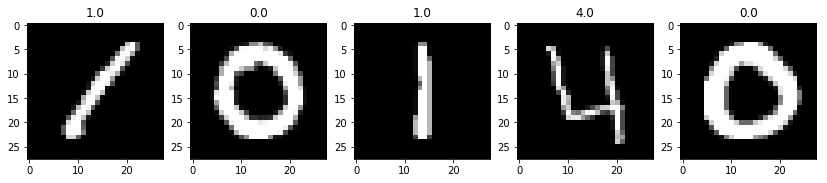

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [7]:
# test_sobel_x = np.zeros_like(test_img)
# test_sobel_y = np.zeros_like(test_img)
# for i in range(len(test_img)):
#     test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
#     test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [9]:
# test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

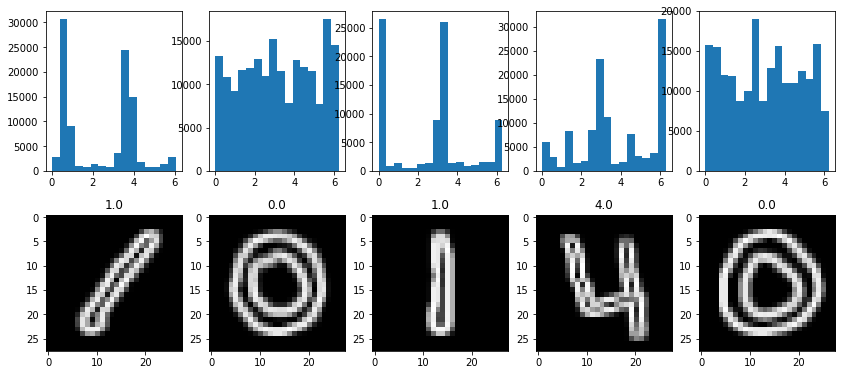

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [11]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [12]:
# test_hist = np.zeros((len(test_img), 16))
# for i in range(len(test_img)):
#     hist, borders = np.histogram(test_theta[i],
#                                  bins=16,
#                                  range=(0., 2. * np.pi),
#                                  weights=test_g[i])
#     test_hist[i] = hist

## Нормируем вектор гистограммы

In [13]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [14]:
# test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [15]:
train_hist.shape

(42000, 16)

### Теперь разложим наши картинки с помощью SVD преобразования и запишем их в качестве дополнительных признаков

In [16]:
train.shape#, test.shape

(42000, 785)

In [17]:
data_for_svd = train[:, 1:]
data_for_svd.shape

(42000, 784)

In [18]:
data_mean = np.mean(data_for_svd, axis=0)
data_for_svd -= data_mean

In [19]:
cov_matrix = np.dot(data_for_svd.T, data_for_svd) / data_for_svd.shape[0]

In [20]:
U, S, _ = np.linalg.svd(cov_matrix)

In [21]:
S_thr = 0.83
S_cumsum = 0
for i in range(S.shape[0]):
    S_cumsum += S[i]/np.sum(S)
    if S_cumsum >= S_thr:
        n_comp = i+1
        print ('n_comp:', n_comp, '\t', 'cumsum:', S_cumsum)
        break

n_comp: 52 	 cumsum: 0.8317983857725973


In [22]:
data_reduced = np.dot(data_for_svd, U[:, :n_comp])
data_reduced.shape

(42000, 52)

Получили по 52 признака для каждого примера, теперь присоединим их к гистограммам и снова разделим на train и test

In [23]:
train_data_svd = data_reduced[:42000]
test_data_svd = data_reduced[42000:]
train_data_svd.shape, test_data_svd.shape

((42000, 52), (0, 52))

In [24]:
train_data = np.hstack((train_hist, train_data_svd))
# test_data = np.hstack((test_hist, test_data_svd))
train_data.shape#, test_data.shape

(42000, 68)

### Самые частые ошибки между 6 и 9, а так же между 3 и 8. Для более лучшего разделения первой пары поделим картинку на две по горизонтали, для разделения второй пары - по вертикали. Найдем их гистограммы и добавим к признакам.

In [25]:
(h, w) = train_img.shape[1:]
(cX, cY) = (int(w * 0.5), int(h * 0.5))
        
segments = [(0, w, 0, cY), 
            (0, w, cY, h),
            (0, cX, 0, h),
            (cX, w, 0, h)]

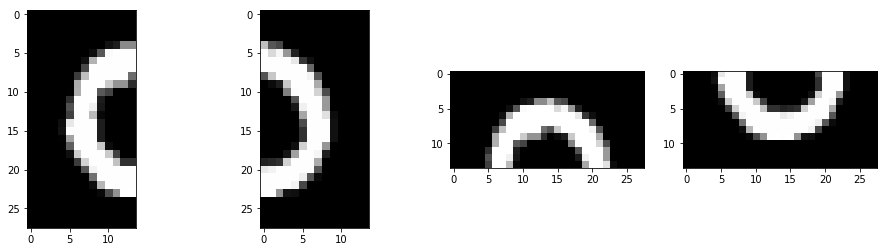

In [26]:
# посмотрим правильно ли разделились сигменты
fig = plt.figure(figsize=(16, 4))
for num, i in enumerate(segments, 1):
    subplot = fig.add_subplot(1, 4, num)
    plt.imshow(train_img[1, i[0]:i[1], i[2]:i[3]], cmap='gray')

In [27]:
for i in segments:
    train_img_s = train_img[:, i[0]:i[1], i[2]:i[3]]
#     test_img_s = test_img[:, i[0]:i[1], i[2]:i[3]]
    train_sobel_x = np.zeros_like(train_img_s)
    train_sobel_y = np.zeros_like(train_img_s)
    for i in range(len(train_img_s)):
        train_sobel_x[i] = cv2.Sobel(train_img_s[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
        train_sobel_y[i] = cv2.Sobel(train_img_s[i], cv2.CV_64F, dx=0, dy=1, ksize=3)
#     test_sobel_x = np.zeros_like(test_img_s)
#     test_sobel_y = np.zeros_like(test_img_s)
#     for i in range(len(test_img_s)):
#         test_sobel_x[i] = cv2.Sobel(test_img_s[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
#         test_sobel_y[i] = cv2.Sobel(test_img_s[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

    train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
#     test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)


    train_hist = np.zeros((len(train_img_s), 16))
    for i in range(len(train_img_s)):
        hist, borders = np.histogram(train_theta[i],
                                     bins=16,
                                     range=(0., 2. * np.pi),
                                     weights=train_g[i])
        train_hist[i] = hist

#     test_hist = np.zeros((len(test_img_s), 16))
#     for i in range(len(test_img_s)):
#         hist, borders = np.histogram(test_theta[i],
#                                      bins=16,
#                                      range=(0., 2. * np.pi),
#                                      weights=test_g[i])
#         test_hist[i] = hist

    train_hist_part = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
#     test_hist_part = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

    train_data = np.hstack((train_data, train_hist_part))
#     test_data = np.hstack((test_data, test_hist_part))

C:\My Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


In [28]:
train_data.shape#, test_data.shape

(42000, 132)

## Разбиваем выборку на обучение и валидацию

Проверим какая модель лучше справляется с задачей, на деревьях или на линейная 

In [29]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_label, test_size=0.2)

In [31]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((33600, 132), (8400, 132), (33600,), (8400,))

In [32]:
xgb = XGBClassifier(colsample_bytree=1, gamma=0, max_depth=5, reg_alpha=0.6, reg_lambda=0.1, 
                    subsample=0.9, n_jobs=-1, n_estimators=500, learning_rate=0.05)

In [33]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0.6, reg_lambda=0.1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

In [34]:
y_pred = xgb.predict(X_val)

In [35]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_pred))

Accuracy: 0.9778571428571429


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       828
         1.0       0.99      0.99      0.99       915
         2.0       0.98      0.98      0.98       843
         3.0       0.97      0.97      0.97       857
         4.0       0.98      0.99      0.98       753
         5.0       0.98      0.97      0.98       742
         6.0       0.99      0.98      0.99       845
         7.0       0.98      0.98      0.98       943
         8.0       0.95      0.98      0.96       801
         9.0       0.98      0.97      0.97       873

   micro avg       0.98      0.98      0.98      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.98      0.98      0.98      8400



In [37]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[807   1   3   1   1   2   6   2   2   3]
 [  0 902   6   1   1   0   1   4   0   0]
 [  1   0 823   6   1   0   2   4   5   1]
 [  0   2   5 833   0   6   0   2   8   1]
 [  0   1   2   0 742   0   0   1   0   7]
 [  3   0   0  12   0 720   1   0   5   1]
 [  1   1   0   0   4   1 832   0   6   0]
 [  0   0   1   2   0   0   0 927   6   7]
 [  4   1   3   3   1   3   1   2 782   1]
 [  3   0   1   1   7   1   1   5   8 846]]
